In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.__version__

'0.0.3.13'

In [3]:
EXPERIMENT_NAME = '1122-Scene3-LSTM-SmallWindow-UseDD'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 48

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z',
                      'dyaw', 'dpitch', 'droll',
                      'ddyaw', 'ddpitch', 'ddroll']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(18314, 19002)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 12]), torch.Size([3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([48, 12])

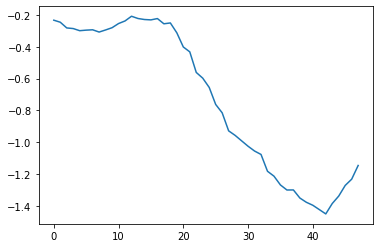

In [11]:
plt.plot(x[:, 2])

In [12]:
model = utils.BaselineLSTM(input_size=12,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.678339
 - Pitch        :  11.859583
 - Roll         :   3.088395
 - RMS          :   9.015877
 - 99% Tile     :  43.988404
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.314232
 - Pitch        :   8.612313
 - Roll         :   3.092793
 - RMS          :   7.538617
 - 99% Tile     :  41.332037
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.048436
 - Pitch        :   8.047291
 - Roll         :   3.091095
 - RMS          :   7.215446
 - 99% Tile     :  39.401896
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.037377
 - Pitch        :   6.836237
 - Roll         :   3.029117
 - RMS          :   6.337958
 - 99% Tile     :  35.169467
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.934102
 - Pitch        :   5.582063
 - Roll         :   2.985471
 - RMS          :   5.009525
 - 99% Tile     :  32.698793
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.228970
 - Pitch        :   4.161525
 - Roll         :   2.913965
 - RMS          :   3.816354
 - 99% Tile     :  29.651368
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.365990
 - Pitch        :   3.309388
 - Roll         :   2.818644
 - RMS          :   3.174203
 - 99% Tile     :  26.845560
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.772107
 - Pitch        :   2.997787
 - Roll         :   2.799260
 - RMS          :   2.858155
 - 99% Tile     :  24.437624
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.685643
 - Pitch        :   2.359646
 - Roll         :   2.805749
 - RMS          :   2.623791
 - 99% Tile     :  22.217400
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.408283
 - Pitch        :   2.062478
 - Roll         :   2.758841
 - RMS          :   2.426579
 - 99% Tile     :  20.315911
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.093209
 - Pitch        :   1.950237
 - Roll         :   2.635109
 - RMS          :   2.245644
 - 99% Tile     :  18.692503
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.743705
 - Pitch        :   1.776581
 - Roll         :   2.145108
 - RMS          :   1.897211
 - 99% Tile     :  16.803316
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.610831
 - Pitch        :   1.870876
 - Roll         :   1.977064
 - RMS          :   1.826083
 - 99% Tile     :  16.138358
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.423047
 - Pitch        :   1.591869
 - Roll         :   1.744490
 - RMS          :   1.591891
 - 99% Tile     :  14.184018
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.444382
 - Pitch        :   1.493416
 - Roll         :   1.585846
 - RMS          :   1.509022
 - 99% Tile     :  13.877958
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.368506
 - Pitch        :   1.505908
 - Roll         :   1.453742
 - RMS          :   1.443830
 - 99% Tile     :  13.034852
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.255797
 - Pitch        :   1.464349
 - Roll         :   1.371651
 - RMS          :   1.366598
 - 99% Tile     :  12.318611
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.307063
 - Pitch        :   1.360729
 - Roll         :   1.363099
 - RMS          :   1.343879
 - 99% Tile     :  12.113133
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.141267
 - Pitch        :   1.250088
 - Roll         :   1.159119
 - RMS          :   1.184450
 - 99% Tile     :  11.944115
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.382944
 - Pitch        :   1.207972
 - Roll         :   1.138536
 - RMS          :   1.247396
 - 99% Tile     :  11.906300
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.173319
 - Pitch        :   1.274084
 - Roll         :   1.204356
 - RMS          :   1.217982
 - 99% Tile     :  11.215795
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.141801
 - Pitch        :   1.233662
 - Roll         :   1.081695
 - RMS          :   1.154079
 - 99% Tile     :  10.497314
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.145341
 - Pitch        :   1.145450
 - Roll         :   1.105246
 - RMS          :   1.132171
 - 99% Tile     :  10.529059
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.243960
 - Pitch        :   1.073309
 - Roll         :   1.134193
 - RMS          :   1.152653
 - 99% Tile     :  10.284862
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.168913
 - Pitch        :   1.035647
 - Roll         :   0.998829
 - RMS          :   1.070293
 - 99% Tile     :  10.096029
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.930382
 - Pitch        :   1.076166
 - Roll         :   1.018285
 - RMS          :   1.010057
 - 99% Tile     :   9.505654
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.935261
 - Pitch        :   0.994334
 - Roll         :   0.957086
 - RMS          :   0.962536
 - 99% Tile     :   9.663987
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.012339
 - Pitch        :   1.116392
 - Roll         :   0.962226
 - RMS          :   1.032318
 - 99% Tile     :   9.388323
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.953623
 - Pitch        :   1.088774
 - Roll         :   0.939961
 - RMS          :   0.996386
 - 99% Tile     :   9.241225
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.090905
 - Pitch        :   0.965548
 - Roll         :   0.957624
 - RMS          :   1.006546
 - 99% Tile     :   9.200525
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.075801
 - Pitch        :   1.006934
 - Roll         :   0.887300
 - RMS          :   0.993070
 - 99% Tile     :   9.182770
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.982579
 - Pitch        :   1.182459
 - Roll         :   0.919047
 - RMS          :   1.034137
 - 99% Tile     :   9.304777
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.976987
 - Pitch        :   0.920676
 - Roll         :   0.905597
 - RMS          :   0.934925
 - 99% Tile     :   9.200799
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.099829
 - Pitch        :   1.107332
 - Roll         :   0.931792
 - RMS          :   1.049451
 - 99% Tile     :   9.243714
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.022616
 - Pitch        :   0.932884
 - Roll         :   0.937570
 - RMS          :   0.965238
 - 99% Tile     :   9.439538
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.029016
 - Pitch        :   1.078534
 - Roll         :   0.870886
 - RMS          :   0.996753
 - 99% Tile     :   9.178769
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.939405
 - Pitch        :   0.886510
 - Roll         :   0.843883
 - RMS          :   0.890790
 - 99% Tile     :   9.408079
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.946239
 - Pitch        :   0.906664
 - Roll         :   0.834868
 - RMS          :   0.897109
 - 99% Tile     :   9.229446
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.940172
 - Pitch        :   0.893922
 - Roll         :   0.821934
 - RMS          :   0.886678
 - 99% Tile     :   9.169487
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.015756
 - Pitch        :   0.873642
 - Roll         :   0.868359
 - RMS          :   0.921784
 - 99% Tile     :   9.144470
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.911968
 - Pitch        :   0.881469
 - Roll         :   0.848530
 - RMS          :   0.881037
 - 99% Tile     :   9.072764
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.943202
 - Pitch        :   0.972301
 - Roll         :   0.837449
 - RMS          :   0.919478
 - 99% Tile     :   9.118063
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.899665
 - Pitch        :   0.945124
 - Roll         :   0.836264
 - RMS          :   0.894799
 - 99% Tile     :   9.109783
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.946450
 - Pitch        :   0.905619
 - Roll         :   0.837584
 - RMS          :   0.897675
 - 99% Tile     :   9.283855
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.936116
 - Pitch        :   0.957234
 - Roll         :   0.839515
 - RMS          :   0.912396
 - 99% Tile     :   9.230328
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.967555
 - Pitch        :   0.872683
 - Roll         :   0.836073
 - RMS          :   0.893823
 - 99% Tile     :   9.265202
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.912819
 - Pitch        :   0.860762
 - Roll         :   0.800359
 - RMS          :   0.859209
 - 99% Tile     :   9.089125
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.957243
 - Pitch        :   0.851182
 - Roll         :   0.805476
 - RMS          :   0.873617
 - 99% Tile     :   9.450830
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.934033
 - Pitch        :   0.856336
 - Roll         :   0.820141
 - RMS          :   0.871466
 - 99% Tile     :   9.382507
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.927133
 - Pitch        :   0.885522
 - Roll         :   0.846452
 - RMS          :   0.886981
 - 99% Tile     :   9.451595
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.960854
 - Pitch        :   0.895375
 - Roll         :   0.864150
 - RMS          :   0.907688
 - 99% Tile     :   9.302276
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.949090
 - Pitch        :   0.885439
 - Roll         :   0.803954
 - RMS          :   0.881498
 - 99% Tile     :   9.265378
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.931034
 - Pitch        :   0.885787
 - Roll         :   0.818054
 - RMS          :   0.879518
 - 99% Tile     :   9.278498
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.920458
 - Pitch        :   0.862096
 - Roll         :   0.808481
 - RMS          :   0.864888
 - 99% Tile     :   9.308687
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.952375
 - Pitch        :   0.913893
 - Roll         :   0.800539
 - RMS          :   0.891269
 - 99% Tile     :   9.281972
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/72 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.930436
 - Pitch        :   0.884102
 - Roll         :   0.800718
 - RMS          :   0.873403
 - 99% Tile     :   9.344004
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0056.npy


[0057/0100] Validation: 100%|██████████████████████| 75/75 [00:04<00:00, 15.69it/s, val_loss 5.1825]


Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.913689
 - Pitch        :   0.875174
 - Roll         :   0.814187
 - RMS          :   0.868650
 - 99% Tile     :   9.320229
Save output signals into checkpoint/1122-Scene3-LSTM-SmallWindow-UseDD/sample/0057.npy
